# Energy Demand Forecasting - Data Load

## Packages

In [2]:
# psycopg2: python package to deal with a postgres database
# pip install psycopg2
import psycopg2
from psycopg2.extras import execute_values

In [3]:
import numpy as np
import pandas as pd
import warnings

from datetime import datetime, timedelta

import urllib.request
import json

# Librería para obtener el usuario que está ejecutando el script
import getpass

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import matplotlib.dates as mdates

import traceback

import hashlib

warnings.filterwarnings("ignore", category=Warning)
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.10f}'.format

# Try I

## Exploratory Tests

Endpoint de la API de cammesa:
https://api.cammesa.com/demanda-svc/swagger-ui.html#/

In [114]:
conn = psycopg2.connect(database='cammesa_db', host='localhost', user='postgres', password='postgres', port=5432)
cursor = conn.cursor()

In [116]:
sql_query = """SELECT MAX(timestamp) AS max_timestamp
                FROM cammesa_db.hourly_demand
                WHERE timestamp < """ + """'2022-11-06 09:05'"""
cursor.execute(sql_query)
data = cursor.fetchall()
pd.DataFrame(data=data)

,0
0,2022-11-06 09:00:00


In [126]:
n_lookback = 48
last_timestamp = datetime(2022, 11, 6, 9, 00)
sql_query = """SELECT timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday 
                        FROM cammesa_db.hourly_demand 
                        WHERE timestamp >= '""" + (last_timestamp+timedelta(hours=-n_lookback)).strftime('%Y-%m-%d %H:%M') +"'" +\
                    """AND timestamp <= '""" + last_timestamp.strftime('%Y-%m-%d %H:%M') +"'"+\
                    """ORDER BY timestamp"""
cursor.execute(sql_query)
data = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
df_lookback = pd.DataFrame(data=data, columns=colnames)
df_lookback.shape[0]

46

In [ ]:
conn.close()

In [128]:
date=datetime.now()
date.hour

13

In [157]:
response = None
_request = 'https://api.cammesa.com/demanda-svc/demanda/RegionesDemanda'
_request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha=2022-11-05&id_region=1002'
try:
    response = urllib.request.urlopen(_request)
    data = response.read()
    encoding = response.info().get_content_charset('utf-8')
    response.close()
    JSON_object = json.loads(data.decode(encoding))
    df = pd.json_normalize(JSON_object)
except Exception as ex:
    print(ex)

In [158]:
df.fecha = pd.to_datetime(df.fecha.astype(str).str[:19], format='%Y-%m-%d %H:%M:%S')
#df[df.fecha.dt.minute==0]
#df = df[df.fecha.dt.minute==0]

In [159]:
df

,fecha,dem,temp
0,2022-11-05 00:05:00,14779,NaN
1,2022-11-05 00:10:00,14679,NaN
2,2022-11-05 00:15:00,14528,18.700
3,2022-11-05 00:20:00,14613,NaN
4,2022-11-05 00:25:00,14432,NaN
...,...,...,...
283,2022-11-05 23:40:00,14448,NaN
284,2022-11-05 23:45:00,14404,20.000
285,2022-11-05 23:50:00,14363,NaN
286,2022-11-05 23:55:00,14294,NaN


In [33]:
response.status

200

## Funciones Soporte

In [4]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                      user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor

In [140]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if cursor else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

In [142]:
def _url_request_to_pandas(_request, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not _request):
        process_ok = False
        error_txt = 'ERROR api_request_to_pandas: No API statement provided.'
        if verbose:
            print(error_txt)
    else:
        try:
            response = urllib.request.urlopen(_request)
            data = response.read()
            encoding = response.info().get_content_charset('utf-8')
            response.close()
            JSON_object = json.loads(data.decode(encoding))
            df = pd.json_normalize(JSON_object)
            if verbose:
                print('INFO api_request_to_pandas: API request executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR api_request_to_pandas: Error requesting API: ' + _request +'\n' + txt
    return process_ok, error_txt, df

In [144]:
def is_holiday(date=datetime.now(), verbose=True):
    is_a_holiday = 0
    _request = 'http://nolaborables.com.ar/api/v2/feriados/'+str(date.year)
    process_ok, error_txt, df_holidays = _url_request_to_pandas(_request, verbose)
    if not process_ok:
        if verbose:
            print('ERROR is_holiday. ' + error_txt)
    else:
        is_a_holiday = int(df_holidays[(df_holidays.dia==date.day) & (df_holidays.mes==date.month)].shape[0] > 0)
        if verbose:
            print('INFO is_holiday. URL request for ' + str(date) + ' Ok.')
    return process_ok, error_txt, is_a_holiday

In [178]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
#plot_event(df_hist, element, '2021-09-01', '2022-08-30', ['press_suc', 'press_1', 'press_2'], [], title=element
#    , xposition=[], yposition=[33.9, 89, 90], fig_size=[15, 5], return_df=False)

def plot_event(df_, time_since, time_until, left_feat_lst, right_feat_lst, title="", xposition=[], yposition=[]
    , fig_size=[10, 3], return_df=True):
    """Plot a spot in the timeline of an element
        PARAMS:
        df_: dataframe source of data (must have fields "element" and "timestamp")
        element *: element name in PI
        time_since *: timestamp start of period to plot
        time_until *: timestamp end of period to plot
        left_feat_lst *: list of dataframe features to plot using left axis
        right_feat_lst *: list of dataframe features to plot using right axis
        xposition: list of vertical lines to draw
    """
    colors_lst=['deepskyblue', 'skyblue', 'steelblue', 'dodgerblue', 'indianred', 'firebrick', 'marron', 'lightsalmon', 'darkorange', 'orange']
    fig, ax = plt.subplots()
    df_plot = df_[(df_.element==element) & (df_.timestamp.between(time_since, time_until))]
    for idx, feat in enumerate(left_feat_lst):
        df_plot.plot(x='timestamp', y=feat, ax=ax, style='-', color=colors_lst[idx], figsize=(fig_size[0], fig_size[1]))
    i=idx+1
    for idx, feat in enumerate(right_feat_lst):
        df_plot.plot(x='timestamp', y=feat, ax=ax, style='--', color=colors_lst[i+idx], figsize=(fig_size[0], fig_size[1])
            , secondary_y=True, lw=1)
    plt.title(title)
   
    # same ax as above since it's automatically added on the right
    #df_plot.plot(x='timestamp', y='rpm', ax=ax, style='r-', secondary_y=True);
    #ax.set_ylim([0, 40]);
    for xc in xposition:
        ax.axvline(x=xc, color='r', linestyle='--', lw=1);
    for yc in yposition:
        ax.axhline(y=yc, color='r', linestyle='--', lw=1);
    return df_plot if return_df else np.nan

## Funciones de DAGs

In [173]:
def _get_hourly_demand(date, database, host, user, password, port, verbose=True):
    """ Asks API for hourly data of the day (from PARAM date %Y-%m-%d %H:%M) and upserts hourly_demand table.
        NOTE: demand values sometimes come in Nan. This modules ends with error in these cases.
        NOTE: values for 00:00 Hour comes with the data form the day before! So there is an special treatment for this situation
    """
    error_txt = ''
    process_ok = True
    if not date:
        date=datetime.now()
    process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)
    if not process_ok:
        if verbose:
            print('ERROR _get_hourly_demand calling subprocess: ' + error_txt)
    else:
        if date.hour == 0:
            # Shoul ask API for the day before
            yesterday = date.date() + timedelta(days=-1)
            _request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha='+\
                        str(yesterday)+'&id_region=1002'
        else:
            _request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha='+\
                        str(date.date())+'&id_region=1002'
        process_ok, error_txt, df_demand = _url_request_to_pandas(_request, verbose)
        if not process_ok:
            if verbose:
                print(error_txt)
                cnxn.close()
        elif df_demand.shape[0]==0:
            if verbose:
                print('INFO get_hourly_demand. No data retrieved from API. Date: ' + date.strftime('%Y-%m-%d %H:%M'))
        else:
            df_demand.fecha = pd.to_datetime(df_demand.fecha.astype(str).str[:19], format='%Y-%m-%d %H:%M:%S')
            # As you are executing this process any time, depends on when Airflow is alive, you have to be sure that
            # you retrieve the data by the logical time it should have been triggered. 
            # So you have to filter hours after logical date.hour
            df_demand = df_demand[(df_demand.fecha.dt.minute==0) & (df_demand.fecha <= date)]
            # demand values can come as Nan --> exclude those records.
            df_demand.dropna(axis=0, subset=['dem'], inplace=True)
            hours = date.hour
            # As hours start in 1, we should ask directly for hour:
            if df_demand.shape[0]<hours:
                if verbose:
                    print('INFO get_hourly_demand - Data retrieved form API is incomplete. Date: ' + str(date) +\
                        ' Hour: ' + str(hours) + ' # of records Ok (should be == to Hour+1): '+ str(df_demand.shape[0]))
            else:
                df_demand.dem = df_demand.dem.astype(int)
                df_demand['day_of_week'] = df_demand.fecha.dt.dayofweek
                process_ok, error_txt, is_a_holiday = is_holiday(date.date(), verbose=verbose)
                if not process_ok:
                    if verbose:
                        print(error_txt)
                    cnxn.close()
                else:
                    df_demand['is_holiday'] = is_a_holiday
                    upsert_user=getpass.getuser()
                    tup = [tuple(np.append(np.append([1002], r), [upsert_user, datetime.now(), upsert_user, datetime.now()])) \
                            for r in df_demand.to_numpy()]
                    sql = 'INSERT INTO cammesa_db.hourly_demand '+\
                        '(region_code, timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday, create_user, create_date, '+\
                        'update_user, update_date) VALUES %s ON CONFLICT (region_code, timestamp) DO UPDATE '+\
                        'SET hourly_demand=EXCLUDED.hourly_demand, hourly_temp=EXCLUDED.hourly_temp, day_of_week=EXCLUDED.day_of_week, '+\
                        'is_holiday=EXCLUDED.is_holiday, update_user=EXCLUDED.update_user, update_date=EXCLUDED.update_date;'
                    execute_values(cursor, sql, tup)
                    cnxn.commit()
                    print('INFO get_hourly_demand - ' + str(len(tup)) + ' records were upserted. Table cammesa_db.hourly_demand.')
        cnxn.close()
    return process_ok


In [176]:
#conn = psycopg2.connect(database='cammesa_db', host='localhost', user='postgres', password='postgres', port=5432)
_get_hourly_demand(datetime(2022, 11, 5, 15, 55), database='cammesa_db', host='localhost', user='postgres', password='postgres'
    , port=5432, verbose=True)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 288
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-11-05 Ok.
INFO get_hourly_demand - 15 records were upserted. Table cammesa_db.hourly_demand.


True

In [339]:
sql_query = """select case 
	when actual_ts is not null then actual_ts
	else future_ts
	end as ts
	, hourly_demand
	, hourly_demand_forecast
	, hourly_temp
from
(
	select A.timestamp as actual_ts
		, A.hourly_demand
		, A.hourly_temp
		, F.timestamp as future_ts
		, F.hourly_demand_forecast 
		from cammesa_db.hourly_demand A
	full outer join cammesa_db.hourly_demand_forecast F on F.timestamp = A.timestamp
) as subquery
where actual_ts >= '2022-10-26'
order by actual_ts, future_ts
			"""
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db', host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
	print('ERROR en conexión')
else:
	process_ok, error_txt, df_superset = pg_select_to_pandas(cursor, sql_query, verbose=True)
	if not process_ok:
		print('ERROR en query ')
#df_superset

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 311


In [192]:
def plot_df(df_, time_since, time_until, time_col, left_feat_lst, right_feat_lst, title="", xposition=[], yposition=[]
    , fig_size=[10, 3], return_df=True):
    """Plot a spot in the timeline of an element
        PARAMS:
        df_: dataframe source of data (must have fields "ts")
        ts *: timestamp column in df_
        time_since *: ts start of period to plot
        time_until *: ts end of period to plot
        left_feat_lst *: list of dataframe features to plot using left axis
        right_feat_lst *: list of dataframe features to plot using right axis
        xposition: list of vertical lines to draw
    """
    colors_lst=['deepskyblue', 'skyblue', 'steelblue', 'dodgerblue', 'indianred', 'firebrick', 'marron', 'lightsalmon', 'darkorange', 'orange']
    fig, ax = plt.subplots()
    df_plot = df_[(df_[time_col].between(time_since, time_until))]
    for idx, feat in enumerate(left_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='-', color=colors_lst[idx], figsize=(fig_size[0], fig_size[1]))
    i=idx+1
    for idx, feat in enumerate(right_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='--', color=colors_lst[i+idx], figsize=(fig_size[0], fig_size[1])
            , secondary_y=True, lw=1)
    plt.title(title)
   
    # same ax as above since it's automatically added on the right
    #df_plot.plot(x='ts', y='rpm', ax=ax, style='r-', secondary_y=True);
    #ax.set_ylim([0, 40]);
    for xc in xposition:
        ax.axvline(x=xc, color='r', linestyle='--', lw=1);
    for yc in yposition:
        ax.axhline(y=yc, color='r', linestyle='--', lw=1);
    return df_plot if return_df else np.nan

nan

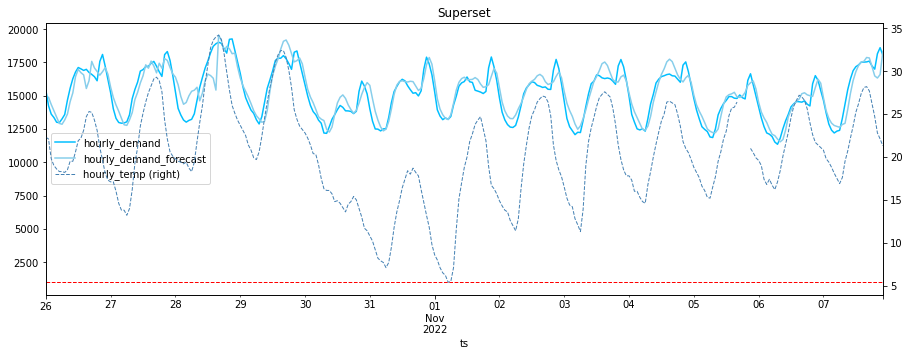

In [340]:
plot_df(df_superset, '2022-10-26', '2022-11-12', 'ts', ['hourly_demand', 'hourly_demand_forecast'], ['hourly_temp'], title='Superset'
    , xposition=[], yposition=[1000], fig_size=[15, 5], return_df=False)


# Try II

Pregunta: Conviene utilizar para predecir la variable "ajustada" con posterioridad?

ERROR forecast 24 hs: se debe contemplar que, llegando al final del día, los datos horarios vengan en Nan y, por lo tanto, no se actualice la base de datos. Se debe agregar lógica para que durante el día posterior se consulte también el día anterior para poder completar esos datos. Están quedando días sin horas desde las 21 hs.

OTRO ERROR: cuando el forecast vá a buscar los datos, como la ejecución se hace cuando el Airflow está despierto, puede que no alcance con buscar el timestamp máximo, para el momento en que se ejecuta el proceso, puede que haya muchos datos más, y por eso el forecast dá mal. Hay que consultar por timestamp max , < que la fecha de ejecución (la lógica, no la real)

https://cammesaweb.cammesa.com/informe-sintesis-mensual/#

Pronóstico meteorológico del Servicio Meteorológico Nacional
https://odp-aws-smn.github.io/documentation_wrf_det/

https://www.smn.gob.ar/descarga-de-datos

Con estas consultas se pueden bajar txt con las temperaturas históricas de Argentina x Estación Meteorológica
https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario20200629.txt
https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario20220701.txt

### 1- Python Web Scrapping usint beautifulsoup

In [5]:
#!pip install beautifulsoup4
#https://www.crummy.com/software/BeautifulSoup/bs4/doc/
#import the Beautiful soup functions to parse the data returned from the website
from bs4 import BeautifulSoup

#import the library used to query a website
import requests

import os

import zipfile

In [6]:
path_data = r'C:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data'

In [4]:
#specify the url
url = "https://cammesaweb.cammesa.com/informe-sintesis-mensual/?tax%5Bwpdmcategory%5D=sintesis-mensual"
#Query the website and return the html to the variable 'page'
page = requests.get(url)
#Parse the html in the 'page' variable, and store it in Beautiful Soup format
#soup = BeautifulSoup(page)
soup = BeautifulSoup(page.text, 'html.parser')
# Imprime la estructura del html (es muy larga)
#print(soup.prettify())

### 2- Download informes históricos
La página de cammesa publica 1 informe zippeado por mes.
Sin embargo, cada informe incluye datos históricos de años anteriores.
Por lo tanto, para armar la base histórica, se bajarán sólo algunos informes mensuales (asumiendo que el último año, el más reciente de cada informe será tomado del informe posterior, por las notas de Cammesa que indican que las cifras se van ajustando a posteriori)

In [8]:
def download_file(url: str, dest_file: str, dest_folder: str, verbose=True):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

        #filename = url.replace(" ", "_")  # be careful with file names
    file_path = os.path.join(dest_folder, dest_file)

    r = requests.get(url, stream=True)
    if r.ok:
        if verbose:
            print("saving to", os.path.abspath(file_path))
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))

In [6]:
bases_lst = ['2015-12', '2018-12', '2019-12', '2022-09']
files_url_dct = {}
# linea 850
# Find downloads buttons, then search for the key needed:
# actual month = 'https://cammesaweb.cammesa.com/download/demanda-mensual'
# history = 'https://cammesaweb.cammesa.com/download/base-informe-mensual-2016-02'
links=soup.find_all('a', attrs={'class': 'wpdm-download-link download-on-click btn btn-primary btn-sm'})
for link in links:
    url = link.get('data-downloadurl')
    for base in bases_lst:
        if 'base' in  url and base in url:
            print(url, 'zip')
            files_url_dct[base] = url
path_data = '..\data'
for base in bases_lst:
    download_file(url=files_url_dct[base], dest_folder=path_data, dest_file='base_informe_mensual_'+base+'.zip')

https://cammesaweb.cammesa.com/download/base_informe_mensual_2022-09/?wpdmdl=43095&refresh=636c3466ba1b21668035686 zip
https://cammesaweb.cammesa.com/download/base-informe-mensual-2019-12/?wpdmdl=36553&refresh=636c3468b9a101668035688 zip
https://cammesaweb.cammesa.com/download/base-informe-mensual-2018-12/?wpdmdl=36528&refresh=636c3468eb3aa1668035688 zip
https://cammesaweb.cammesa.com/download/base-informe-mensual-2015-12/?wpdmdl=36451&refresh=636c34698668d1668035689 zip
saving to c:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data\base_informe_mensual_2015-12.zip
saving to c:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data\base_informe_mensual_2018-12.zip
saving to c:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data\base_informe_mensual_2019-12.zip
saving to c:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data\base_informe_mensual_2022-09.zip


### 3- Unzip files

In [7]:
for base in bases_lst:
    zip_file = os.path.join(path_data, 'base_informe_mensual_'+ base + '.zip')
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(path_data, base.replace('-', '_')))
    ## If file exists, delete it: if os.path.isfile(myfile):
    os.remove(zip_file)

### 4- Download weather data

In [14]:
pd.options.display.float_format = '{:.1f}'.format

In [22]:
df_list = []
for single_date in (datetime(2022, 10, 28) + timedelta(n) for n in range(19)):
    # print(single_date.strftime("%Y%m%d"))
    date = single_date.strftime("%Y%m%d")
    download_file(url='https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario'+date+'.txt'
    , dest_folder=os.path.join(path_data, 'weather'), dest_file=date+'.txt', verbose=False)
    df_txt = pd.read_fwf(os.path.join(path_data, 'weather', date+'.txt'), widths=[8, 6, 6, 5, 8, 5, 5, 100], encoding='latin-1')
    # Delete rows with empty date --> are format errors of the txt. No data is lost:
    df_txt.drop(df_txt[df_txt.FECHA.isna()].index.tolist(), axis=0, inplace=True)
    # Build timestamp from columns:
    df_txt['timestamp'] = pd.to_datetime(date + " " + df_txt.HORA.str.strip().str.zfill(2) + ":00", format='%Y%m%d %H:%M')    
    # Get ride of columns you dont need:
    # Dates should be 10 chars long, if it is less, day should be fill with leading zeros:
    df_txt.drop(columns=['FECHA', 'HORA'], inplace=True)
    cols = ['temp', 'humidity', 'press', 'dd', 'wind', 'met_station', 'timestamp']
    df_txt.columns = cols
    df_txt.met_station = df_txt.met_station.str.strip()
    df_txt.temp.str.replace('.', ',')
    df_txt.temp = df_txt.temp.astype(float)
    df_txt.press.str.replace('.', ',')
    df_txt.press = df_txt.press.astype(float)
    # NaN values goes to -1:
    df_txt.humidity.fillna('-1', inplace=True)
    df_txt.humidity = df_txt.humidity.astype(int)
    df_txt.dd.fillna('-1', inplace=True)
    df_txt.dd = df_txt.dd.astype(int)
    df_txt.wind.fillna('-1', inplace=True)
    df_txt.wind = df_txt.wind.astype(int)
    df_list.append(df_txt)
    os.remove(os.path.join(path_data, 'weather', date+'.txt'))
df_weather = pd.concat(df_list)
df_weather.reset_index(drop=True, inplace=True)
df_weather

,temp,humidity,press,dd,wind,met_station,timestamp
0,21.0,33,1007.3,320,11,AEROPARQUE AERO,2022-10-28 00:00:00
1,19.2,39,1007.2,320,9,AEROPARQUE AERO,2022-10-28 01:00:00
2,19.8,34,1006.8,320,9,AEROPARQUE AERO,2022-10-28 02:00:00
3,19.5,37,1006.4,320,13,AEROPARQUE AERO,2022-10-28 03:00:00
4,18.8,46,1006.3,320,9,AEROPARQUE AERO,2022-10-28 04:00:00
...,...,...,...,...,...,...,...
40522,32.5,25,1009.5,50,13,VILLA REYNOLDS AERO,2022-11-15 19:00:00
40523,29.4,31,1009.9,360,7,VILLA REYNOLDS AERO,2022-11-15 20:00:00
40524,26.6,32,1010.5,360,17,VILLA REYNOLDS AERO,2022-11-15 21:00:00
40525,25.0,36,1010.8,360,19,VILLA REYNOLDS AERO,2022-11-15 22:00:00


In [51]:
# document.getElementsByTagName('a')[157].href
#https://ssl.smn.gob.ar/dpd/zipopendata.php?dato=estaciones
download_file(url='https://ssl.smn.gob.ar/dpd/zipopendata.php?dato=estaciones'
    , dest_folder=os.path.join(path_data, 'weather'), dest_file='met_stations.zip', verbose=False)

In [53]:
zip_file = os.path.join(path_data, 'weather', 'met_stations.zip')
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(path_data, 'weather'))
os.remove(zip_file)

In [63]:
df_txt.TURA.astype(int).max()

3459

In [69]:
df_txt = pd.read_fwf(os.path.join(path_data, 'weather', 'estaciones_smn.txt'), widths=[31, 37, 9, 9, 9, 9, 4, 7, 5]
    , encoding='latin-1')
# Delete rows with empty columns --> are format errors of the txt. No data is lost:
df_txt.drop(df_txt[df_txt.NOMBRE.isna()].index.tolist(), axis=0, inplace=True)
df_txt.drop(df_txt[df_txt.PROVINCIA.isna()].index.tolist(), axis=0, inplace=True)
cols = ['met_station', 'province', 'lat_gr', 'lat_min', 'long_gr', 'long_min', 'height', 'met_station_id', 'ACI']
df_txt.columns = cols
df_txt.met_station = df_txt.met_station.str.strip()
df_txt.province = df_txt.province.str.strip()
df_txt.lat_gr = df_txt.lat_gr.astype(int)
df_txt.lat_min = df_txt.lat_min.astype(int)
df_txt.long_gr = df_txt.long_gr.astype(int)
df_txt.long_min = df_txt.long_min.astype(int)
df_txt.height = df_txt.height.astype(int)
df_txt.met_station_id = df_txt.met_station_id.astype(int)
# Convertion from gr and min to decimal degrees:
# Decimal Degrees = degrees + (minutes/60) + (seconds/3600)
df_txt['lat'] = df_txt.lat_gr + (df_txt.lat_min/60)
df_txt['long'] = df_txt.long_gr + (df_txt.long_min/60)
df_txt

,met_station,province,lat_gr,lat_min,long_gr,long_min,height,met_station_id,ACI,lat,long
1,BASE BELGRANO II,ANTARTIDA,-77,52,-34,38,256,89034,SAYB,-76.1,-33.4
2,BASE CARLINI (EX JUBANY),ANTARTIDA,-62,14,-58,40,11,89053,SAYJ,-61.8,-57.3
3,BASE ESPERANZA,ANTARTIDA,-63,24,-57,0,24,88963,SAYE,-62.6,-57.0
4,BASE MARAMBIO,ANTARTIDA,-64,14,-56,38,198,89055,SAWB,-63.8,-55.4
5,BASE ORCADAS,ANTARTIDA,-60,44,-44,44,12,88968,SAYO,-59.3,-43.3
...,...,...,...,...,...,...,...,...,...,...,...
121,SANTIAGO DEL ESTERO AERO,SANTIAGO DEL ESTERO,-27,45,-64,18,199,87129,SANE,-26.2,-63.7
122,TERMAS DE RIO HONDO AERO,SANTIAGO DEL ESTERO,-27,30,-64,56,280,87127,SANR,-26.5,-63.1
123,RIO GRANDE B.A.,TIERRA DEL FUEGO,-53,47,-67,46,22,87934,SAWE,-52.2,-66.2
124,USHUAIA AERO,TIERRA DEL FUEGO,-54,50,-68,18,57,87938,SAWH,-53.2,-67.7


In [70]:
df_txt.to_csv(os.path.join(path_data, 'weather', 'estaciones_smn.csv'))

# Armado de la base Histórica
Historia 2012++
* Tabla de agentes (verificar si los de demanda son los mismos de los de generación): agente nemo | agente desc | tipo (demanda)<br>
* Tabla de máquinas: máquina | tipo máquina | fuente generación | tecnología | cat hidráulica<br>
* Tabla de region: region | cat región (generación) <br>
* Demanda: mes | agente | region | prov | cat area | cat demanda | tarifa | cat tarifa | demanda MWh <br>
* Generación: mes | maquina | central | agente | region | generación_neta MWh <br>

NOTA: los informes se publican hacia el 18 de cada mes!!!

## Funciones Soporte DB

In [ ]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                      user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor


In [ ]:
def masive_insert(table, df, cursor, cnxn):
    bool_raise = False
    error_txt = ''
    user=getpass.getuser()
    df['create_date'] = datetime.now()
    df['create_user'] = user
    df['update_date'] = datetime.now()
    df['update_user'] = user
    tup = [tuple(r) for r in df.to_numpy()]
        
    cols_to_insert = f'({(", ".join(df.columns.tolist()))})'
        
    sql = "INSERT INTO "+table+" "+cols_to_insert+" VALUES %s"
    try:
        execute_values(cursor, sql, tup)
        cnxn.commit()
        print(f'{df.shape[0]} rows inserted to the {table} table')
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'Masive Insert - SQL Insert Error. SQL: ' + '\n' + sql + '\n' + txt
    return bool_raise, error_txt

In [ ]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if cursor else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

## Monthly Demand

In [6]:
#demanda_lst = []
#i = 0
#cut_off = None
## Se reversa la lista porque se consulta el siguiente dataset para ver qué años trae:
#for base in bases_lst[::-1][1:]:
#    file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base+'.xlsx')
#    df = pd.read_excel(file, sheet_name='DEMANDA', header=21, usecols='A:L', decimal=',')
#    if not cut_off:
#        cut_off = df.MES.min()# + relativedelta(years=-1)
#        print(cut_off, df.MES.min(), df.MES.max())
#        df = df[df.MES<=cut_off]
#    demanda_lst.append(df)

demanda_lst = []
cut_off = None
# [2] A partir de 2020 la base del informe mensual comienza a venir en exceles separados para cada tipo de datos.
# Se integran los exceles de los 3 primeros datasets con el excel correspondiente a demanda del último dataset:
base = bases_lst[3]
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Demanda_INFORME_MENSUAL'
    , 'Demanda Mensual.xlsx')
df = pd.read_excel(file, sheet_name='DEMANDA', header=23, usecols='A:L', decimal=',')
demanda_lst.append(df)
cut_off = df.MES.min()# + relativedelta(years=-1)

# [1] En los 3 primeros datasets se toman todos los años menos el último, que se toma del dataset siguiente:
# Se reversa la lista porque se consulta el siguiente dataset para ver qué años trae:
for base in bases_lst[::-1][1:]:
    file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base+'.xlsx')
    df = pd.read_excel(file, sheet_name='DEMANDA', header=21, usecols='A:L', decimal=',')
    df = df[df.MES<cut_off]
    cut_off = df.MES.min()# + relativedelta(years=-1)
    demanda_lst.append(df)

df_demanda = pd.concat(demanda_lst)
print(df_demanda.columns)
df_demanda.MES.min(), df_demanda.MES.max()

# [3] Se renombran las columnas para trabajar mejor
cols = ['year', 'month', 'agent_id', 'agent_desc', 'agent_dem_type', 'region_desc', 'prov_desc'
    , 'area_categ', 'demand_categ', 'tariff_desc', 'tariff_categ', 'monthly_demand_mwh']
df_demanda.columns = cols
# Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
# de agentes
df_demanda['agent_desc'] = df_demanda.agent_desc.str.strip()
df_demanda['tariff_id'] = df_demanda.apply(lambda x: 
    hashlib.sha1(str.encode(x.tariff_desc.strip().lower()+x.tariff_categ.strip().lower())).hexdigest()[:10], axis=1)
df_demanda.sort_values(by=['month', 'agent_id'], inplace=True)
df_demanda.reset_index(drop=True, inplace=True)

print(df_demanda.shape[0])
df_demanda.head(2)

NameError: name 'bases_lst' is not defined

## Monthly Generation

In [206]:
# [1] Starting 2020, the monthly reports changes it structure and each dimention starts to come in separate excels.
generacion_lst = []
base = bases_lst[3]
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
    , 'Generación Local Mensual.xlsx')
df = pd.read_excel(file, sheet_name='GENERACION', header=21, usecols='A:O', decimal=',')
generacion_lst.append(df)
# Keep the inital month of this dataset to avoid data duplication between datasets
cut_off = df.MES.min()

# [2] Then, we process other 3 datasets in order to have al data. We do it backwards to avoid data duplication
for base in bases_lst[::-1][1:]:
    file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base+'.xlsx')
    df = pd.read_excel(file, sheet_name='GENERACION', header=21, usecols='A:N', decimal=',')
    if '|' in df.columns:
        df.rename(columns={'|': 'MAQUINA'}, inplace=True)
    if 'GENERACION NETA [MWh]' in df.columns:
        df.rename(columns={'GENERACION NETA [MWh]': 'GENERACION NETA'}, inplace=True)
    df = df[df.MES<cut_off]
    cut_off = df.MES.min() # + relativedelta(years=-1)
    generacion_lst.append(df)

df_generacion = pd.concat(generacion_lst)
df_generacion.reset_index(drop=True, inplace=True)
print(df_generacion.columns)

# [3] Se renombran las columnas para trabajar mejor
cols = ['year', 'month', 'machine_code', 'central_id', 'agent_id', 'agent_desc', 'region_desc', 'prov_desc', 'pais'
    , 'machine_type', 'source_gen', 'technology', 'hidraulic_categ', 'region_categ', 'monthly_gen_mwh']
df_generacion.columns = cols
# Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
# de agentes
df_generacion['agent_id'] = df_generacion.agent_id.str.strip()
df_generacion['agent_desc'] = df_generacion.agent_desc.str.strip()
df_generacion['machine_code'] = df_generacion.machine_code.str.strip()
df_generacion.prov_desc.fillna('', inplace=True)

# único país existente = Argentina
df_generacion.drop(columns='pais', inplace=True)

df_generacion.sort_values(by=['month', 'machine_code'], inplace=True)
df_generacion.reset_index(drop=True, inplace=True)

df_generacion['machine_id'] = df_generacion.apply(lambda x: 
    hashlib.sha1(str.encode(x.machine_code.strip().lower()+x.machine_type.strip().lower()+x.technology.strip().lower())).hexdigest()[:10], axis=1)

print(df_generacion.shape[0])
df_generacion.head(2)

Index(['AÑO', 'MES', 'MAQUINA', 'CENTRAL', 'AGENTE', 'AGENTE DESCRIPCION', 'REGION', 'PROVINCIA', 'PAIS', 'TIPO MAQUINA', 'FUENTE GENERACION', 'TECNOLOGIA', 'CATEGORIA HIDRAULICA', 'CATEGORIA REGION', 'GENERACION NETA'], dtype='object')
87125


,year,month,machine_id,central_id,agent_id,agent_desc,region_desc,prov_desc,machine_type,source_gen,technology,hidraulic_categ,region_categ,monthly_gen_mwh
0,2012,2012-01-01,3ARRDI01,3ARR,QUIL3A3A,QUILMES - PLANTA TRES ARROYOS,BUENOS AIRES,NaN,MOTOR DIESEL,Térmica,DI,NaN,Gba - Litoral - Buenos Aires,0
1,2012,2012-01-01,ACAJTG01,CAPE,CAPEX-QA,CAPEX S.A. AUTOGENERADOR,COMAHUE,NaN,TURBO GAS,Térmica,CC,NaN,Comahue,21869


## Prices

Precios, Combustibles y Potencia instalada están todos los años.<br>
IMPO EXPLO empieza 2013 <br>
Caudales diarios, cotas 2019++<br>

In [301]:
# [0] 2022's dataset features data since 2016. So, we integrate only first and last datasets
# [1] Starting 2020, the monthly reports changes it structure and each dimention starts to come in separate excels.
precios_lst = []
base = bases_lst[3]
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Adicionales_INFORME_MENSUAL'
    , 'Precios Mensuales.xlsx')
df = pd.read_excel(file, sheet_name='PRECIOS', header=4, usecols='A:CE', decimal=',')
df.drop(columns=['COMPONENTES GENERALES'], inplace=True)
df.set_index(keys=['DETALLE'], inplace=True)
df = df.T
df.reset_index(inplace=True)
precios_lst.append(df)

base = bases_lst[0]
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base+'.xlsx')
df = pd.read_excel(file, sheet_name='PRECIOS', header=4, usecols='A:AX', decimal=',')
df.drop(columns=['COMPONENTES GENERALES'], inplace=True)
df.set_index(keys=['DETALLE'], inplace=True)
df = df.T
df.reset_index(inplace=True)
precios_lst.append(df)
df_precios = pd.concat(precios_lst)

df_precios = pd.concat(precios_lst)
cols = ['month', 'energia', 'energia_ad', 'sobrecost_comb', 'sobrecost_transit_despacho', 'carg_dem_exce_cta_brasil_contrat_abas_MEM'
    , 'pot_despachada', 'pot_serv_asoc', 'pot_res_corto_plzo_serv_res_intantanea', 'pot_res_med_plzo', 'monodico'
    , 'transp_alta_tens_distrib_troncal', 'transp_alta_tens', 'transp_distrib_troncal', 'monodico_transp'
    , 'monodico_ponder_estacional_otr_ingr', 'cargo_demanda_exced_real', 'cta_brasil_abast_MEM', 'compra_conj_MEM'
    , 'monodico_ponder_estacional_transp']
df_precios.columns = cols

df_precios.sort_values(by=['month'], inplace=True)
df_precios.reset_index(drop=True, inplace=True)

df_precios['carg_dem_exce_cta_brasil_contrat_abas_MEM'].fillna(0, inplace=True)
df_precios.pot_despachada.fillna(0, inplace=True)
df_precios.pot_serv_asoc.fillna(0, inplace=True)
df_precios.compra_conj_MEM.fillna(0, inplace=True)
df_precios['monodico_ponder_estacional_transp'].fillna(0, inplace=True)

print(df_precios.columns, df_precios['month'].min(), df_precios['month'].max(), df_precios.shape[0])

Index(['month', 'energia', 'energia_ad', 'sobrecost_comb', 'sobrecost_transit_despacho', 'carg_dem_exce_cta_brasil_contrat_abas_MEM', 'pot_despachada', 'pot_serv_asoc', 'pot_res_corto_plzo_serv_res_intantanea', 'pot_res_med_plzo', 'monodico', 'transp_alta_tens_distrib_troncal', 'transp_alta_tens', 'transp_distrib_troncal', 'monodico_transp', 'monodico_ponder_estacional_otr_ingr', 'cargo_demanda_exced_real', 'cta_brasil_abast_MEM', 'compra_conj_MEM', 'monodico_ponder_estacional_transp'], dtype='object') 2013-01-01 00:00:00 2022-09-01 00:00:00 117


In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.monthly_prices'
start_loop = datetime.now()
index_ini = df_precios.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_precios), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_precios))
    df_data_to_insert = df_precios[(df_precios.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 117
117 rows inserted to the cammesa_db.monthly_prices table
Execution time: 0.00 hours 0.00 minutes 0.00 seconds Rows Inserted: 117


## Installed Pot
Comes with only the actual month, so you have to download and process ALL monthly reports.
I decided not to include this information.

## Combustibles
This data merges combustibles of different types. May be, it will be wise to group by type. Also, they have differents units of measures: Unidad: GAS NATURAL [Dam3] - FUEL OIL [Ton] - GAS OIL [M3] - CARBÓN  MINERAL [Ton] - BIODIESEL [Ton]

In [333]:
comb_lst = []
base = bases_lst[3]
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
    , 'Combustibles Mensual.xlsx')
df = pd.read_excel(file, sheet_name='COMBUSTIBLES', header=21, usecols='A:M', decimal=',')
df.drop(columns=['REGION', 'PROVINCIA'], inplace=True)
comb_lst.append(df)
# Keep the inital month of this dataset to avoid data duplication between datasets
cut_off = df.MES.min()

# [2] Then, we process other 3 datasets in order to have al data. We do it backwards to avoid data duplication
for base in bases_lst[::-1][1:]:
    file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base+'.xlsx')
    df = pd.read_excel(file, sheet_name='COMBUSTIBLES', header=21, usecols='A:N', decimal=',')
    df = df[df.MES<cut_off]
    cut_off = df.MES.min() # + relativedelta(years=-1)
    comb_lst.append(df)

df_combustibles = pd.concat(comb_lst)
print(df_combustibles.columns)

# Drop columns
df_combustibles.drop(columns=['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], inplace=True)

# [3] Se renombran las columnas para trabajar mejor
cols = ['year', 'month', 'machine_code', 'central_id', 'agent_id', 'agent_desc', 'machine_type', 'source_gen', 'technology'
    , 'combustible_type', 'monthly_consume']
df_combustibles.columns = cols
# Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
# de agentes
df_combustibles['agent_id'] = df_combustibles.agent_id.str.strip()
df_combustibles['agent_desc'] = df_combustibles.agent_desc.str.strip()
df_combustibles['machine_code'] = df_combustibles.machine_code.str.strip()

df_combustibles.sort_values(by=['month', 'machine_code'], inplace=True)
df_combustibles.reset_index(drop=True, inplace=True)

df_combustibles['machine_id'] = df_combustibles.apply(lambda x: 
    hashlib.sha1(str.encode(x.machine_code.strip().lower()+x.machine_type.strip().lower()+x.technology.strip().lower())).hexdigest()[:10], axis=1)

print(df_combustibles.shape[0])
df_combustibles.head(2)

Index(['AÑO', 'MES', 'MAQUINA', 'CENTRAL', 'AGENTE', 'AGENTE DESCRIPCION', 'TIPO MAQUINA', 'FUENTE GENERACION', 'TECNOLOGIA', 'COMBUSTIBLE', 'CONSUMO', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], dtype='object')
41678


,year,month,machine_code,central_id,agent_id,agent_desc,machine_type,source_gen,technology,combustible_type,consume,machine_id
0,2012,2012-01-01,ACAJTG01,CAPE,CAPEX-QA,CAPEX S.A. AUTOGENERADOR,TURBO GAS,Térmica,CC,GAS NATURAL,10752,9425bd700b
1,2012,2012-01-01,ACAJTG02,ACAJ,CAPEXSAG,C.T. AGUA DEL CAJON,TURBO GAS,Térmica,CC,GAS NATURAL,10049,b9e4df6699


## Availability
By Central

In [354]:
avail_lst = []
base = bases_lst[3]
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
    , 'Disponibilidad Mensual.xlsx')
df = pd.read_excel(file, sheet_name='DISPONIBILIDAD x CENTRAL', header=21, usecols='A:G', decimal=',')
avail_lst.append(df)
# Keep the inital month of this dataset to avoid data duplication between datasets
cut_off = df.MES.min()

# [2] Then, we process other 3 datasets in order to have al data. We do it backwards to avoid data duplication
# This data starts on 2016
for base in bases_lst[::-1][1:3]:
    file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base+'.xlsx')
    df = pd.read_excel(file, sheet_name='DISPONIBILIDAD x CENTRAL', header=21, usecols='A:G', decimal=',')
    df = df[df.MES<cut_off]
    cut_off = df.MES.min() # + relativedelta(years=-1)
    avail_lst.append(df)

df_availability = pd.concat(avail_lst)
print(df_availability.columns)

# [3] Se renombran las columnas para trabajar mejor
cols = ['month', 'central_id', 'agent_id', 'agent_desc', 'technology_desc', 'technology', 'monthly_availability_factor']
df_availability.columns = cols
# Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
# de agentes
df_availability['agent_id'] = df_availability.agent_id.str.strip()
df_availability['central_id'] = df_availability.central_id.str.strip()
df_availability['year'] = df_availability.month.dt.year

df_availability.sort_values(by=['month', 'central_id', 'technology'], inplace=True)
df_availability.reset_index(drop=True, inplace=True)

print(df_availability.shape[0])
df_availability.head(2)

Index(['MES', 'Central', 'Agente', 'DESCRIPCION', 'Tecnología Descripción', 'Tecnología', 'FACTOR DISPONIBILIDAD TEC [%]'], dtype='object')
15893


,month,central_id,agent_id,agent_desc,technology_desc,technology,availability_factor,year
0,2016-01-01,ABRO,CTBROWNG,C.T. ALMIRANTE BROWN,Motor Diesel,DI,1,2016
1,2016-01-01,ACAJ,CAPEXSAG,C.T. AGUA DEL CAJON,Ciclos Combinados,CC,1,2016


In [ ]:
df_technologies = df_availability[['technology', 'technology_desc']].copy().drop_duplicates(subset=['technology', 'technology_desc'])
df = pd.DataFrame(data=[['HID', 'Hidráulica'], ['EOL', 'Eólica'], ['BIOM', 'Biomasa'], ['MHID', 'MHID'], ['SOL', 'Solar'], ['HR', 'HR']],
    columns=['technology', 'technology_desc'])
df_technologies = pd.concat([df_technologies, df])

process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.gen_technologies'
start_loop = datetime.now()
index_ini = df_technologies.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_technologies), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_technologies))
    df_data_to_insert = df_technologies[(df_technologies.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 12
12 rows inserted to the cammesa_db.gen_technologies table
Execution time: 0.00 hours 0.00 minutes 0.00 seconds Rows Inserted: 12


## IMPO EXPO
History since 2013

In [370]:
IE_lst = []
base = bases_lst[3]
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Adicionales_INFORME_MENSUAL'
    , 'Import-Export Mensual.xlsx')
df = pd.read_excel(file, sheet_name='IMP-EXP', header=23, usecols='A:E', decimal=',')
IE_lst.append(df)
# Keep the inital month of this dataset to avoid data duplication between datasets
cut_off = df.MES.min()

# [2] Then, we process other 3 datasets in order to have al data. We do it backwards to avoid data duplication
# This data starts on 2016
for base in bases_lst[::-1][1:]:
    file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base+'.xlsx')
    df = pd.read_excel(file, sheet_name='IMP-EXP', header=23, usecols='A:E', decimal=',')
    df = df[df.MES<cut_off]
    cut_off = df.MES.min() # + relativedelta(years=-1)
    IE_lst.append(df)

df_import_export = pd.concat(IE_lst)
print(df_import_export.columns)

# [3] Se renombran las columnas para trabajar mejor
cols = ['year', 'month', 'pais', 'import_export_type', 'monthly_energy_mwh']
df_import_export.columns = cols
df_import_export['year'] = df_import_export.month.dt.year

df_import_export.sort_values(by=['month', 'import_export_type', 'pais'], inplace=True)
df_import_export.reset_index(drop=True, inplace=True)

print(df_import_export.shape[0])
df_import_export.head(2)

Index(['AÑO', 'MES', 'PAIS', 'TIPO', 'ENERGÍA'], dtype='object')
938


,year,month,pais,import_export_type,energy_mwh
0,2013,2013-01-01,Brasil,Exportación,5
1,2013,2013-01-01,Chile,Exportación,0


In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.monthly_import_export'
start_loop = datetime.now()
index_ini = df_import_export.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_import_export), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_import_export))
    df_data_to_insert = df_import_export[(df_import_export.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 938
938 rows inserted to the cammesa_db.monthly_import_export table
Execution time: 0.00 hours 0.00 minutes 0.00 seconds Rows Inserted: 938


## Agents Master
Hay 25 agentes que tienen 2 denominaciones a través de la historia, 12 realmente tienen distinta denominación. <br>
En el maestro aparecerán con las 2 denominaciones en el mismo campo.

In [62]:
df_ = df_demanda.drop_duplicates(subset=['agent_id', 'agent_desc', 'agent_dem_type']).groupby(['agent_id']).\
            agg({'agent_desc': 'count'})
df_.reset_index(inplace=True)
df_agentes_doble_desc = df_[df_.agent_desc>1]
agentes_doble_desc = {}
for agente in df_agentes_doble_desc.agent_id.tolist():
    df_ = df_demanda[df_demanda.agent_id==agente][['agent_id', 'agent_desc']].drop_duplicates().copy()
    df_.reset_index(inplace=True)
    if df_.loc[0].agent_desc.replace(' ', '') != df_.loc[1].agent_desc.replace(' ', ''):
        agentes_doble_desc[agente] = df_.loc[0].agent_desc + ' | ' + df_.loc[1].agent_desc
agentes_doble_desc

{'APLAMAOY': 'AMERICAN PLAST Pta. Malv. Arg. | BEMIS ARGENTINA Pta.Malv. Arg.',
 'CHEVRNRZ': 'CHEVRON ARGENTINA - RIO NEGRO | AREA RIO NEGRO NORTE',
 'DEMALMOY': 'DEMA S.A. - San Justo | FUNDICIONES SAN JUSTO SA',
 'DEMAP2OY': 'DEMA SA - S. Justo Pta 2 Ombu | FUNDICIONES SAN JUSTO SA POmbu',
 'DGSPCHUD': 'DGSP Chubut-El Coihue | DGSP Chubut',
 'JBS-SASY': 'JBS ARG. SA - EX SWIFT ARMOUR | SWIFT ARGENTINA-ROSARIO',
 'JBSAFAOY': 'JBS ARGENTINA S.A. | SWIFT ARGENTINA-PILAR',
 'MRPLSLSA': 'MOL.RIO PLATA AUTOG. S.L. | MOLINOS AGRO AG.(Ex.Mol Rio P)',
 'NOBLPIOY': 'NOBLEZA PICCARDO - Pilar 2 | BRITISH AMER.TOBACCO - Pilar 2',
 'PBBPBB2Z': 'PBBPOLISUR SA (EX POLIBB2Z) | PBBPOLISUR SA PTA BAHIA BLANCA',
 'TAVEX-TZ': 'TAVEX ARG. - EX SANTISTA TEXT. | SANTISTA ARG. S.A.- EX TAVEX',
 'TOREBRIY': 'TOREDO S.A. - Brandsen | BOXMARK LEATHER SA - Brandsen'}

In [63]:
df_agentes_dem = df_demanda[['agent_id', 'agent_desc', 'agent_dem_type']]\
    .drop_duplicates(subset=['agent_id']).copy()
df_agentes_dem.set_index(keys='agent_id', inplace=True)
for index in agentes_doble_desc:
    df_agentes_dem.at[index, 'agent_desc'] = agentes_doble_desc[index]
df_agentes_dem.reset_index(inplace=True)
print(df_agentes_dem.shape[0])
df_agentes_dem[df_agentes_dem.agent_id == 'TOREBRIY']

626


,agent_id,agent_desc,agent_dem_type
437,TOREBRIY,TOREDO S.A. - Brandsen | BOXMARK LEATHER SA - Brandsen,GU


### Concatenación de los datasets de GENERACIÓN

In [64]:
# Agentes del dataset de generación con más de una descripción:
df_ = df_generacion.drop_duplicates(subset=['agent_id', 'agent_desc'], keep='last')\
    .groupby(['agent_id']).agg({'agent_desc': 'count'})
df_.reset_index(inplace=True)
df_agentes_doble_desc = df_[df_.agent_desc>1]

for agente in df_agentes_doble_desc.agent_id.tolist():
    #print(agente)
    df_ = df_generacion[df_generacion.agent_id==agente][['agent_id', 'agent_desc']].drop_duplicates().copy()
    df_.reset_index(inplace=True)
    if df_.loc[0].agent_desc.replace(' ', '') != df_.loc[1].agent_desc.replace(' ', ''):
        agentes_doble_desc[agente] = df_.loc[0].agent_desc + ' | ' + df_.loc[1].agent_desc
agentes_doble_desc

{'APLAMAOY': 'AMERICAN PLAST Pta. Malv. Arg. | BEMIS ARGENTINA Pta.Malv. Arg.',
 'CHEVRNRZ': 'CHEVRON ARGENTINA - RIO NEGRO | AREA RIO NEGRO NORTE',
 'DEMALMOY': 'DEMA S.A. - San Justo | FUNDICIONES SAN JUSTO SA',
 'DEMAP2OY': 'DEMA SA - S. Justo Pta 2 Ombu | FUNDICIONES SAN JUSTO SA POmbu',
 'DGSPCHUD': 'DGSP Chubut-El Coihue | DGSP Chubut',
 'JBS-SASY': 'JBS ARG. SA - EX SWIFT ARMOUR | SWIFT ARGENTINA-ROSARIO',
 'JBSAFAOY': 'JBS ARGENTINA S.A. | SWIFT ARGENTINA-PILAR',
 'MRPLSLSA': 'MOL.RIO PLATA AUTOG. S.L. | MOLINOS AGRO AG.(Ex.Mol Rio P)',
 'NOBLPIOY': 'NOBLEZA PICCARDO - Pilar 2 | BRITISH AMER.TOBACCO - Pilar 2',
 'PBBPBB2Z': 'PBBPOLISUR SA (EX POLIBB2Z) | PBBPOLISUR SA PTA BAHIA BLANCA',
 'TAVEX-TZ': 'TAVEX ARG. - EX SANTISTA TEXT. | SANTISTA ARG. S.A.- EX TAVEX',
 'TOREBRIY': 'TOREDO S.A. - Brandsen | BOXMARK LEATHER SA - Brandsen',
 'CFCHIM1G': 'C.FOTOV. CHIMBERAS 1-ENARSA | C.FOTOV. CHIMBERAS 1',
 'CHSLOMAG': 'C.H. SALTO DE LA LOMA SIEyE | C.H. SALTO DE LA LOMA',
 'CTBARISG':

In [65]:
# [4] Maestro de agentes de generacion
df_agentes_gen = df_generacion[['agent_id', 'agent_desc']]\
    .drop_duplicates(subset=['agent_id'], keep='last').copy()
df_agentes_gen.set_index(keys='agent_id', inplace=True)
for index in agentes_doble_desc:
    df_agentes_gen.at[index, 'agent_desc'] = agentes_doble_desc[index]
df_agentes_gen.reset_index(inplace=True)
print(df_agentes_gen.shape[0])
df_agentes_gen[df_agentes_gen.agent_id == 'PERAWS1G']

504


,agent_id,agent_desc
249,PERAWS1G,P.EOLICO RAWSON I - ENARSA | P.EOLICO RAWSON I


In [66]:
# Agentes del dataset de generación que coinciden con los del dataset de demanda: 39
df_demanda[['agent_id']].drop_duplicates(subset=['agent_id']).merge(
    right=df_generacion[['agent_id']].drop_duplicates(subset=['agent_id'])
    , how='inner', on='agent_id', suffixes=('_x', '_y')).shape[0]

39

In [67]:
df_merge = df_agentes_dem.merge(right=df_agentes_gen, how='outer', on='agent_id', suffixes=('_x', '_y'))
df_agentes_gen[df_agentes_gen.agent_id.isin(df_merge[df_merge.agent_desc_x.isna()].agent_id.tolist())]

,agent_id,agent_desc
1,TPOWERCG,TERMOROCA-TURBINE POWER COMP.
2,CTLOMITG,CT LAS LOMITAS - ENARSA
3,CTABROWG,C.T. ALMIRANTE BROWN - ENARSA
4,CTALEMNG,CT ALEM - ENARSA
5,CTALUMIG,CT ALUMINÉ - ENARSA
...,...,...
487,EMISSANG,EMSA GENERACION
488,CTPOLLOG,CTBG POLLOS SAN MATEO
490,PSBKINGG,P.SOLAR ALTO TINOG2 BINGO KING
491,PSBADROG,P.SOLAR ALTO TINOG3 BGOADROGUE


In [116]:
# [5] Finalmente, la tabla maestra:
df_agentes = pd.concat([df_agentes_dem, 
    df_agentes_gen[df_agentes_gen.agent_id.isin(df_merge[df_merge.agent_desc_x.isna()].agent_id.tolist())]])
df_agentes.reset_index(drop=True, inplace=True)
df_agentes.agent_dem_type.fillna('', inplace=True)
df_agentes.head()

,agent_id,agent_desc,agent_dem_type
0,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU
1,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU
2,ACARSLSY,ASOC.COOP.ARG. - San Lorenzo,GU
3,ACINROSY,ACINDAR ROSARIO EX-NAVARRO,GU
4,ACINTBOY,ACINDAR PTA. TABLADA,GU


In [ ]:
table = 'cammesa_db.agents'
start_loop = datetime.now()
index_ini = df_agentes.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_agentes), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_agentes))
    df_data_to_insert = df_agentes[(df_agentes.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        break
    
if bool_raise:
    print(error_txt)
    cnxn.close()
else:
    end_loop = datetime.now()
    hours = (end_loop-start_loop).seconds//3600
    minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
    seconds = (end_loop-start_loop).seconds%60
    print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
            'Rows Inserted:', totRows)

Inicio 0 loop actual 0 loop final 1080
1080 rows inserted to the cammesa_db.agents table
Execution time: 0.00 hours 0.00 minutes 0.00 seconds Rows Inserted: 1080


## Geography Hierarchy
Del análisis de los datos, se deduce que la región no tiene que ver con la provincia (una provincia pertenece a más de una región, ej: Buenos Aires)<br>
Con lo cual, este dato deberá quedar atado al agente.


In [ ]:
df_demanda.drop_duplicates(subset=['region_desc', 'prov_desc'])[['region_desc', 'prov_desc']].sort_values(by=['region_desc', 'prov_desc']).shape[0]

25

In [ ]:
df_demanda.drop_duplicates(subset=['agente_id', 'region_desc', 'prov_desc'])[['region_desc', 'prov_desc']].shape[0]

626

## Tariff Master
IMPORTANTE: la tarifa no determina la categoría de tarifa: existe la tarifa "Alumbrado público" con categoría "Comercial" y "Residencial" --> oblica a mantener este dato en el dataset original o generar algún id para las combinaciones.
Hay sólo 2 situaciones, la otra es SANCIONADO DEM.MAYOR O IGUAL 10 Y MENOR300 KW <br>

_**Intentaría armar un id y crear la tabla maestra.**_

In [99]:
df_tarifas = df_demanda[['tariff_desc', 'tariff_categ']].\
    drop_duplicates(subset=['tariff_desc', 'tariff_categ']).\
        sort_values(by='tariff_desc')
df_tarifas['tariff_id'] = df_tarifas.apply(lambda x: 
    hashlib.sha1(str.encode(x.tariff_desc.strip().lower()+x.tariff_categ.strip().lower())).hexdigest()[:10], axis=1)
df_tarifas.reset_index(drop=True, inplace=True)
df_tarifas

,tariff_desc,tariff_categ,tariff_id
0,Alumbrado Publico,Residencial,2435425dfc
1,Alumbrado Publico,Comercial,5e982a88e0
2,GRANDES USUARIOS C DEM MAYOR O IGUAL 300KW,Industrial/Comercial Grande,e545f8a8d6
3,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,9e8d2c58de
4,GUMES/GUPAS,Industrial/Comercial Grande,ba57718861
5,MENOR 10KW NO RES. MAYOR O IGUAL 4000 KWH/BIM,Comercial,2828ab4c1c
6,MENOR 10KW NO RES. MENOR 4000 KWH BIM,Comercial,4818383b13
7,MERCADO TERMINO DISTRIB,Mercado a Término,3360c6d1f0
8,RES. MAYOR 1000 Y MENOR O IGUAL 1400 KWH BIM,Residencial,5f5bb489b8
9,RES. MAYOR 1400 Y MENOR O IGUAL 2800 KWH BIM,Residencial,0d6a2d4432


In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
    
table = 'cammesa_db.tariffs'
start_loop = datetime.now()
index_ini = df_tarifas.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_tarifas), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_tarifas))
    df_data_to_insert = df_tarifas[(df_tarifas.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

Inicio 0 loop actual 0 loop final 37
Masive Insert - SQL Insert Error. SQL: 
INSERT INTO cammesa_db.tariffs (tariff_desc, tariff_categ, tariff_id, create_date, create_user, update_date, update_user) VALUES %s
Traceback (most recent call last):   File "C:\Users\Usuario\AppData\Local\Temp/ipykernel_8344/796776394.py", line 15, in masive_insert     execute_values(cursor, sql, tup)   File "c:\Users\Usuario\miniconda3\envs\pampa\lib\site-packages\psycopg2\extras.py", line 1299, in execute_values     cur.execute(b''.join(parts)) psycopg2.errors.UniqueViolation: llave duplicada viola restricción de unicidad «tariffs_pk» DETAIL:  Ya existe la llave (tariff_id)=(2435425dfc). 
Execution time: 0.00 hours 0.00 minutes 0.00 seconds Rows Inserted: 37


## Machines Master

In [221]:
# 'AMEGHI' --> example of machine with different values of technology and machine_type over the time
df_ = df_generacion.drop_duplicates(subset=['machine_code', 'machine_type', 'source_gen', 'technology', 'hidraulic_categ']).\
    groupby(['machine_code', 'machine_type', 'technology']).agg({'central_id': 'count'})
df_[df_.central_id>1].shape[0]

7

In [227]:
# Machine table:
df_machines = df_generacion.drop_duplicates(subset=['machine_id'])\
    [['machine_id', 'machine_code', 'machine_type', 'source_gen', 'technology', 'hidraulic_categ']]
df_machines.reset_index(drop=True, inplace=True)
df_machines.hidraulic_categ.fillna('', inplace=True)
df_machines

,machine_id,machine_code,machine_type,source_gen,technology,hidraulic_categ
0,fa5673aee7,3ARRDI01,MOTOR DIESEL,Térmica,DI,
1,9425bd700b,ACAJTG01,TURBO GAS,Térmica,CC,
2,b9e4df6699,ACAJTG02,TURBO GAS,Térmica,CC,
3,ffbbc16c9b,ACAJTG03,TURBO GAS,Térmica,CC,
4,42a145cd56,ACAJTG04,TURBO GAS,Térmica,CC,
...,...,...,...,...,...,...
1480,37ca3d5f2c,PSMADI01,BIOGAS,Renovable,BIOG,
1481,6d1a3960d4,ATI1FV,FOTOVOLTAICA,Renovable,SOL,
1482,3cd01fe9b5,ATI2FV,FOTOVOLTAICA,Renovable,SOL,
1483,d25a3dd4b1,ATI3FV,FOTOVOLTAICA,Renovable,SOL,


In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
    raise(error_txt)

table = 'cammesa_db.gen_machines'
start_loop = datetime.now()
index_ini = df_machines.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_machines), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_machines))
    df_data_to_insert = df_machines[(df_machines.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 1485
1485 rows inserted to the cammesa_db.gen_machines table
Execution time: 0.00 hours 0.00 minutes 0.00 seconds Rows Inserted: 1485


## DB Data load of Tables with Foreign Keys

In [146]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.monthly_demand'
start_loop = datetime.now()
index_ini = df_demanda.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_demanda), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_demanda))
    df_data_to_insert = df_demanda[['year', 'month', 'agent_id', 'region_desc', 'prov_desc', 'area_categ', 'demand_categ'
        , 'tariff_id', 'monthly_demand_mwh']][(df_demanda.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 131603
20000 rows inserted to the cammesa_db.monthly_demand table
Inicio 0 loop actual 20000 loop final 131603
20000 rows inserted to the cammesa_db.monthly_demand table
Inicio 0 loop actual 40000 loop final 131603
20000 rows inserted to the cammesa_db.monthly_demand table
Inicio 0 loop actual 60000 loop final 131603
20000 rows inserted to the cammesa_db.monthly_demand table
Inicio 0 loop actual 80000 loop final 131603
20000 rows inserted to the cammesa_db.monthly_demand table
Inicio 0 loop actual 100000 loop final 131603
20000 rows inserted to the cammesa_db.monthly_demand table
Inicio 0 loop actual 120000 loop final 131603
11603 rows inserted to the cammesa_db.monthly_demand table
Execution time: 0.00 hours 0.00 minutes 18.00 seconds Rows Inserted: 131603


In [259]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.monthly_gen'
start_loop = datetime.now()
index_ini = df_generacion.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_generacion), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_generacion))
    df_data_to_insert = df_generacion[['year', 'month', 'machine_id', 'central_id', 'agent_id', 'region_desc', 'region_categ'
        , 'prov_desc', 'monthly_gen_mwh']][(df_generacion.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 87125
20000 rows inserted to the cammesa_db.monthly_gen table
Inicio 0 loop actual 20000 loop final 87125
20000 rows inserted to the cammesa_db.monthly_gen table
Inicio 0 loop actual 40000 loop final 87125
20000 rows inserted to the cammesa_db.monthly_gen table
Inicio 0 loop actual 60000 loop final 87125
20000 rows inserted to the cammesa_db.monthly_gen table
Inicio 0 loop actual 80000 loop final 87125
7125 rows inserted to the cammesa_db.monthly_gen table
Execution time: 0.00 hours 0.00 minutes 15.00 seconds Rows Inserted: 87125


In [341]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.monthly_combustibles'
start_loop = datetime.now()
index_ini = df_combustibles.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_combustibles), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_combustibles))
    df_data_to_insert = df_combustibles[['month', 'machine_id', 'central_id', 'agent_id', 'year'
    , 'combustible_type', 'monthly_consume']]\
        [(df_combustibles.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 41678
20000 rows inserted to the cammesa_db.monthly_combustibles table
Inicio 0 loop actual 20000 loop final 41678
20000 rows inserted to the cammesa_db.monthly_combustibles table
Inicio 0 loop actual 40000 loop final 41678
1678 rows inserted to the cammesa_db.monthly_combustibles table
Execution time: 0.00 hours 0.00 minutes 5.00 seconds Rows Inserted: 41678


In [367]:
#['month', 'central_id', 'agent_id', 'technology', 'monthly_availability_factor', 'year']
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.monthly_availability'
start_loop = datetime.now()
index_ini = df_availability.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_availability), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_availability))
    df_data_to_insert = df_availability[['month', 'central_id', 'agent_id', 'technology', 'year', 'monthly_availability_factor']]\
        [(df_availability.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 15893
15893 rows inserted to the cammesa_db.monthly_availability table
Execution time: 0.00 hours 0.00 minutes 2.00 seconds Rows Inserted: 15893


In [23]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.hourly_weather'
start_loop = datetime.now()
index_ini = df_weather.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_weather), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_weather))
    df_data_to_insert = df_weather[(df_weather.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 40527
20000 rows inserted to the cammesa_db.hourly_weather table
Inicio 0 loop actual 20000 loop final 40527
20000 rows inserted to the cammesa_db.hourly_weather table
Inicio 0 loop actual 40000 loop final 40527
527 rows inserted to the cammesa_db.hourly_weather table
Execution time: 0.00 hours 0.00 minutes 4.00 seconds Rows Inserted: 40527


## Hourly Demand
Since January 2019, monthly report includes an excel file with hourly demand. The sum of the hourly demand "DEMANDA LOCAL [MWh]" of a month is equal to the sum of monthly demand by agent (table monthly_demand)

In [45]:
# [1] Excel load as df
base = '2022-09'
file = os.path.join(path_data, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_2022-09', 'Bases_Demanda_INFORME_MENSUAL'
    , 'Demanda Horaria por Tipo.xlsx')
df_hourly_demand = pd.read_excel(file, sheet_name='Demanda por Tipo', header=3, usecols='A:O', decimal=',')

print(df_hourly_demand.columns)
df_hourly_demand.MES.min(), df_hourly_demand.MES.max()

Index(['AÑO', 'MES', 'N° MES', 'N° DIA', 'TIPO DIA', 'DIA', 'FECHA', 'HORA', 'Gran Usuario MEM', 'DISTRIBUIDOR (demanda estacional+GUMEs)', 'DEMANDA LOCAL [MWh]', 'Exportacion', 'Bombeo', 'Perdidas', 'DEMANDA TOTAL [MWh]'], dtype='object')


(Timestamp('2019-01-01 00:00:00'), Timestamp('2022-09-01 00:00:00'))

In [46]:
# [2] Delete cols without use (we can add them at the feature engineering phase)
df_hourly_demand.drop(columns=['AÑO', 'MES', 'N° MES', 'N° DIA', 'DIA'], inplace=True)
# [3] Rename columns:
cols = ['day_type', 'date', 'time', 'GU_MEM', 'distrib', 'hourly_local_demand_mwh', 'expo', 'pumped', 'losses', 'hourly_total_demand_mwh']
df_hourly_demand.columns = cols
# [4] Build timestamp column:
df_hourly_demand['timestamp'] = pd.to_datetime(df_hourly_demand.date.astype(str) + " " + (df_hourly_demand.time-1).astype(str).str.zfill(2) + ":00"
    , format='%Y-%m-%d %H:%M')
df_hourly_demand.drop(columns=['date', 'time'], inplace=True)
# [5] Sort to massive insert by index
df_hourly_demand.sort_values(by=['timestamp'], inplace=True)
df_hourly_demand.reset_index(drop=True, inplace=True)

In [47]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)

table = 'cammesa_db.hourly_historic_demand'
start_loop = datetime.now()
index_ini = df_hourly_demand.index[0]
step = 20000
totRows = 0
for i in range(index_ini, index_ini+len(df_hourly_demand), step):
    print('Inicio', index_ini, 'loop actual', i, 'loop final', index_ini+len(df_hourly_demand))
    df_data_to_insert = df_hourly_demand[(df_hourly_demand.index.isin(range(i, i+step)))]
    totRows = totRows + df_data_to_insert.shape[0]
    bool_raise, error_txt = masive_insert(table, df_data_to_insert, cursor, cnxn)
    if bool_raise:
        print(error_txt)
        cnxn.close()
        break    
    
end_loop = datetime.now()
hours = (end_loop-start_loop).seconds//3600
minutes = ((end_loop-start_loop).seconds - (hours * 3600))//60
seconds = (end_loop-start_loop).seconds%60
print('Execution time: {0:.2f} hours'.format(hours), '{0:.2f} minutes'.format(minutes), '{0:.2f} seconds'.format(seconds),
         'Rows Inserted:', totRows)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
Inicio 0 loop actual 0 loop final 32856
20000 rows inserted to the cammesa_db.hourly_historic_demand table
Inicio 0 loop actual 20000 loop final 32856
12856 rows inserted to the cammesa_db.hourly_historic_demand table
Execution time: 0.00 hours 0.00 minutes 4.00 seconds Rows Inserted: 32856


# Estudios de Correlaciones
Primer estudio es con las variables completamente sumarizadas a nivel país. Ver correlación entre demanda, generación, precios, combustibles, availability by central (by energy type), import/export.

Pendiente caudales, que no hay historia
Cómo conseguir la temperatura??

Probar los modelos a nivel total país.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates

# List of colors for plots
colors = ['darksalmon',  'royalblue', 'aquamarine', 'darkturquoise', 'magenta', 'maroon', 'lightslategray', 'sienna'
    , 'darkseagreen', 'ghostwhite', 'gold', 'gray', 'goldenrod', 'lightskyblue', 'silver', 'skyblue', 'salmon', 'royalblue'
    , 'saddlebrown', 'aqua', 'sandybrown', 'mediumslateblue', 'mediumaquamarine']

In [305]:
df_dem_mensual = df_demanda[['month', 'monthly_demand_mwh']].groupby('month').agg({'monthly_demand_mwh': 'sum'})
df_dem_mensual.reset_index(inplace=True)
df_gen_mensual = df_generacion[['month', 'monthly_gen_mwh']].groupby('month').agg({'monthly_gen_mwh': 'sum'})
df_gen_mensual.reset_index(inplace=True)
df_precios_mensual = df_precios[['month', 'energia', 'energia_ad'
    , 'carg_dem_exce_cta_brasil_contrat_abas_MEM', 'cargo_demanda_exced_real', 'cta_brasil_abast_MEM'
    , 'monodico', 'monodico_transp', 'monodico_ponder_estacional_otr_ingr', 'monodico_ponder_estacional_transp']]

df_dataset = df_dem_mensual.merge(df_gen_mensual, on='month', how='left')
df_dataset = df_dataset.merge(df_precios_mensual, on='month', how='left')
df_dataset

,month,monthly_demand_mwh,monthly_gen_mwh,energia,energia_ad,carg_dem_exce_cta_brasil_contrat_abas_MEM,cargo_demanda_exced_real,cta_brasil_abast_MEM,monodico,monodico_transp,monodico_ponder_estacional_otr_ingr,monodico_ponder_estacional_transp
0,2012-01-01,10804700,11236939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-02-01,10085552,10462376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-03-01,10175365,10535239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-04-01,8969068,9273244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-05-01,9597272,10069749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
124,2022-05-01,11726718,11426545,930,282,147,11947,4178,5,99,56,0
125,2022-06-01,13073296,12608691,930,479,241,15260,4608,4,92,47,0
126,2022-07-01,12638511,12102954,930,510,217,16693,4662,5,95,51,0
127,2022-08-01,11781433,11317361,930,360,150,14083,4771,5,98,55,0


### Correlacion Lineal

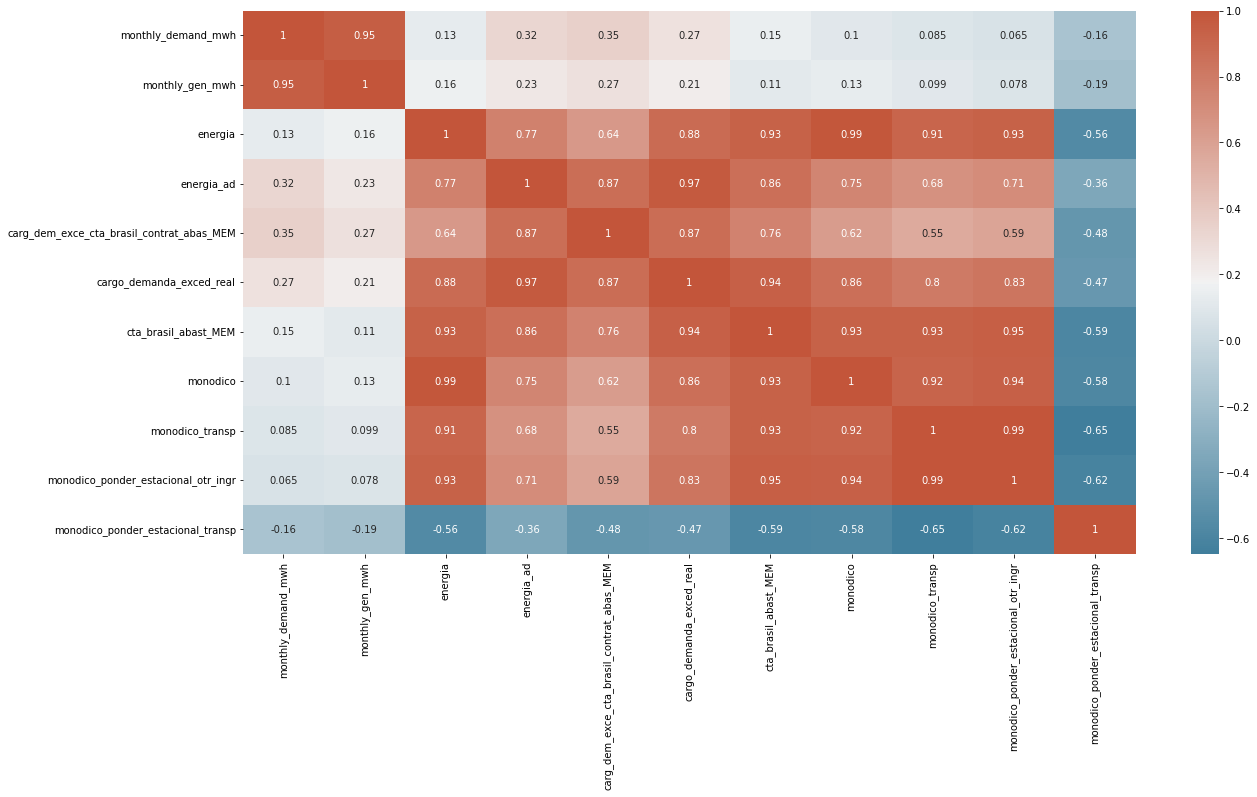

In [306]:
#method{‘pearson’, ‘kendall’, ‘spearman’} default pearson
corr = df_dataset.corr(method='pearson')
%matplotlib inline
plt.figure(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()

### Correlaciones No lineales

In [308]:
# Plotting the PPS matrix:
# (This needs some minor preprocessing because seaborn.heatmap unfortunately does not accept tidy data)
# pip install ppscore
import ppscore as pps

matrix_df = pps.matrix(df_dataset)[['x', 'y', 'ppscore']]\
    .pivot(columns='x', index='y', values='ppscore')

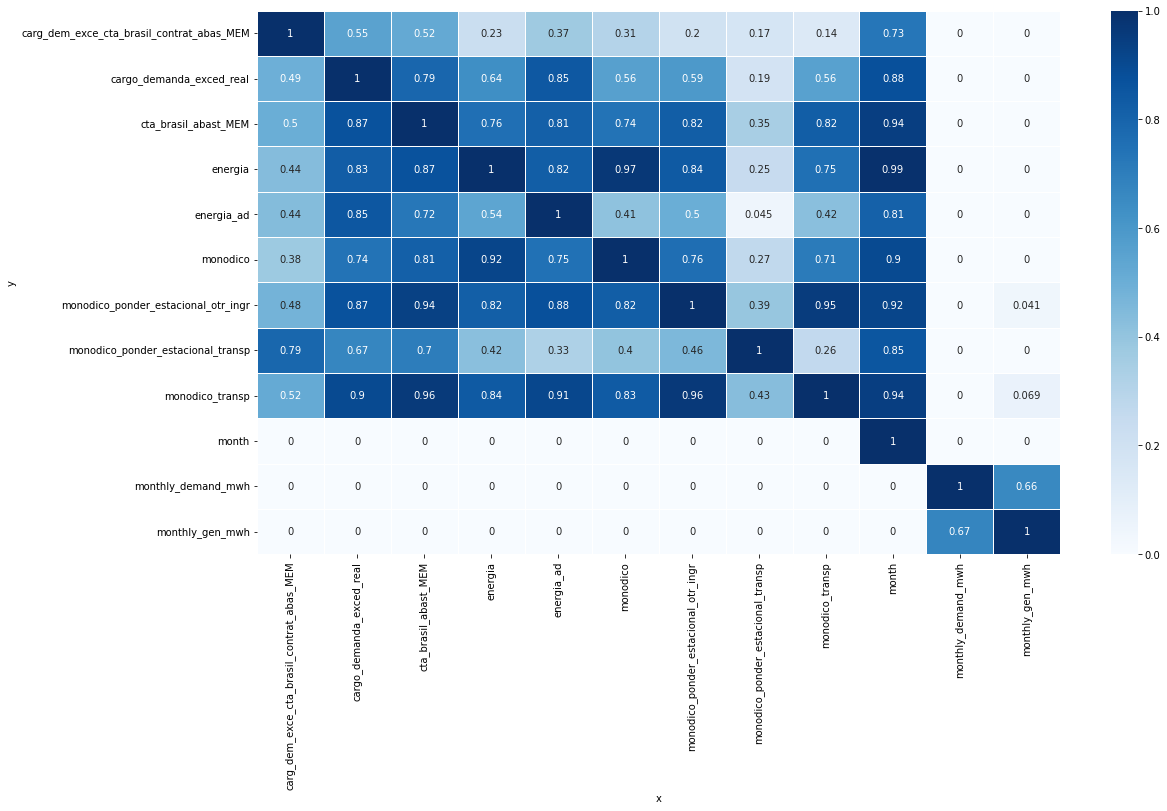

In [309]:
plt.figure(figsize=(18, 10))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True);

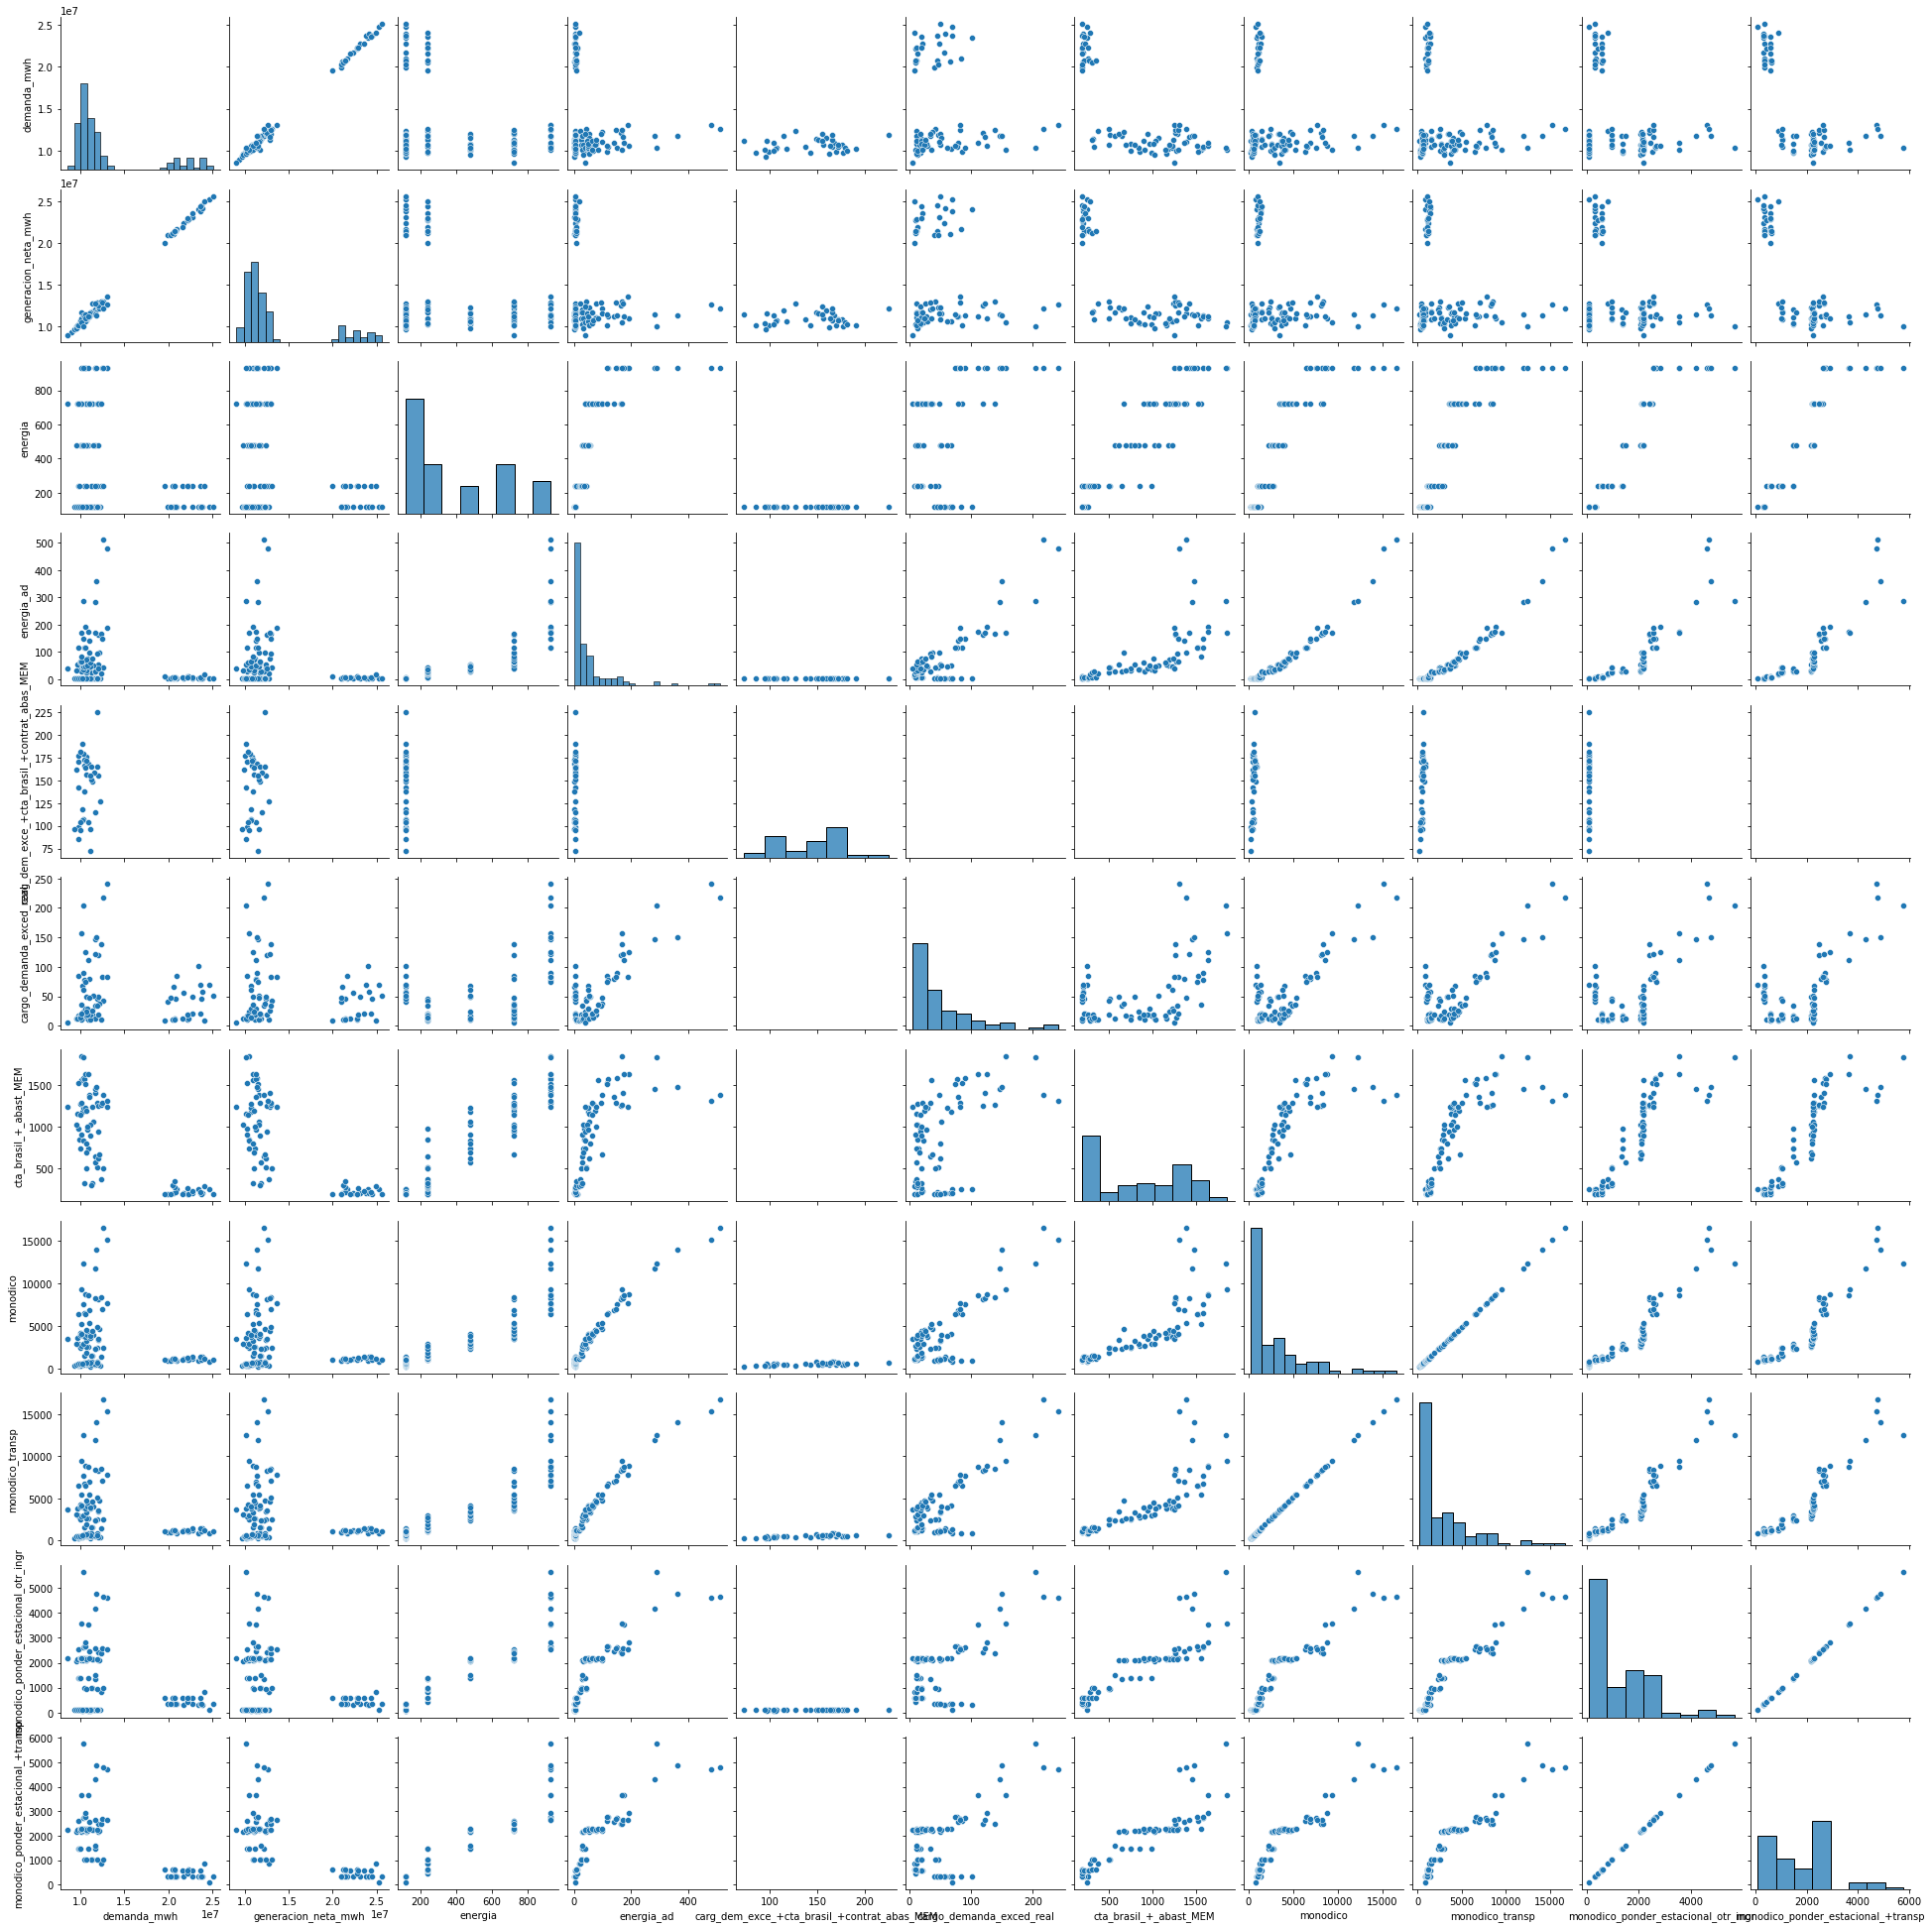

In [118]:
# Create the default pairplot
sns.pairplot(df_dataset)

In [ ]:
# https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/
# https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/
# https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
# https://www.analyticsvidhya.com/blog/2022/05/5-python-libraries-for-time-series-analysis/
# https://www.analyticsvidhya.com/blog/2022/04/an-end-to-end-guide-on-time-series-forecasting-using-fbprophet/
